In [2]:
import time
from collections import defaultdict
import json
import math
import random
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox
from src.plots import plot_quant_vs_ogtt

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LarsCV, LassoCV, LinearRegression, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import xgboost as xgb
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

fg = fg.drop('1091_9_FBG')

In [4]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

## Quick test for one model

In [5]:
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
scoring = 'neg_mean_squared_error'

model = Lasso()
rbg_scores = cross_val_score(
    model,       
    X.loc[rbg_cols],  
    y_ogtt.loc[rbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

fbg_scores = cross_val_score(
    model,       
    X.loc[fbg_cols],  
    y_ogtt.loc[fbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

# Model parameters  

In [5]:
n_repeats, n_splits = 200, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
scoring = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
models = {
    'ols': (LinearRegression(), X_scaled),
    'lasso': (Lasso(alpha=483), X_scaled), # Lasso hyperparameter alpha found from LassoCV
    'ridge': (Ridge(), X_scaled),
    'svm': (SVR(kernel='linear', C=1), X_scaled),
    'pls': (PLSRegression(), X),
    'rf': (RandomForestRegressor(n_estimators=200, max_features=100, random_state=42), X),
}
y = {
    'ogtt': y_ogtt,
#     'insulin': y_insulin,
#     'weight': y_weight,
}

In [6]:
results = {}
for y_name, y_data in y.items(): 
    results[y_name] = {}
    for model_name, (model, x_data) in models.items():
        results[y_name][model_name] = {}
        for bg_type, bg_cols in [('Fed', rbg_cols), ('Fasted', fbg_cols)]:
            print(y_name, model_name, bg_type)
            results[y_name][model_name][bg_type] = \
            cross_validate(
                estimator=model, 
                X=x_data.loc[bg_cols], 
                y=y_data.loc[bg_cols], 
                cv=cv, 
                n_jobs=7,
                scoring=scoring,
                return_estimator=True,)
# results['ogtt']['svm']['Fed']['estimator'][0]

ogtt ols Fed
ogtt ols Fasted
ogtt lasso Fed
ogtt lasso Fasted
ogtt ridge Fed
ogtt ridge Fasted
ogtt svm Fed
ogtt svm Fasted
ogtt pls Fed
ogtt pls Fasted
ogtt rf Fed
ogtt rf Fasted


In [7]:
# with open(r'../data/interim/model_fasted_vs_fed_results.csv', 'w') as f:
#     w = csv.writer(f)
#     w.writerow(header)

all_rows = []

for y_name, y_result in results.items():
    for model_name, model_result in results[y_name].items():
        for i, (bg_type, bg_result) in enumerate(model_result.items()):
            result_list = [y_name, model_name, bg_type]
            importances = []
            for j, est in enumerate(bg_result['estimator']):
                if model_name == 'rf' or model_name == 'xgboost': 
                    importances.append(est.feature_importances_)
                elif model_name == 'svm':
                    importances.append(est.coef_[0])  # only linear kernel has .coef_, 'rbf' does not.
                elif model_name == 'pls':
                    importances.append(est.coef_.T[0])
                else:
                    importances.append(est.coef_)
            result_list.extend(np.mean(importances, axis=0))
            for score in scoring:
                result_list.extend(bg_result['test_' + score])
            all_rows.append(result_list)

In [9]:
header = ['y', 'model', 'x']
header.extend(data.index)
header.extend([score + f'_{x:04}' for score in scoring for x in range(n_repeats * n_splits)])

r = pd.DataFrame(all_rows, columns=header)
score_cols = r.filter(regex='neg_').columns
r.loc[:, score_cols] = -1 * r.loc[:, score_cols]

for i, score in enumerate(scoring, start=3):
    cols = r.filter(regex=score).columns
    r.insert(loc=i, value=r[cols].mean(axis=1), column=score + '_mean')
    r.insert(loc=i, value=r[cols].median(axis=1), column=score + '_median')
    
# r.to_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv')
r

,y,model,x,neg_mean_squared_error_median,r2_median,neg_mean_absolute_percentage_error_median,neg_root_mean_squared_error_median,neg_root_mean_squared_error_mean,neg_mean_absolute_percentage_error_mean,r2_mean,...,neg_root_mean_squared_error_0990,neg_root_mean_squared_error_0991,neg_root_mean_squared_error_0992,neg_root_mean_squared_error_0993,neg_root_mean_squared_error_0994,neg_root_mean_squared_error_0995,neg_root_mean_squared_error_0996,neg_root_mean_squared_error_0997,neg_root_mean_squared_error_0998,neg_root_mean_squared_error_0999
0,ogtt,ols,Fed,3.418586e+07,0.756184,0.137298,5846.867375,5932.672221,0.142928,0.657071,...,6637.280780,6295.279851,5012.392090,5203.431399,5794.853985,7736.172518,4885.495290,4788.564164,7159.026145,5520.211530
1,ogtt,ols,Fasted,5.394558e+07,0.586939,0.157827,7344.765134,7373.461372,0.164725,0.387992,...,4755.677785,3177.247041,11659.164007,10756.798257,7178.945467,7712.038913,6827.232260,10050.125957,4843.441381,8043.253275
2,ogtt,lasso,Fed,3.967842e+07,0.712958,0.144648,6299.081095,6538.404775,0.157515,0.592076,...,5285.378926,7212.713300,6677.232370,6667.013943,4886.138791,5428.289633,7421.546458,5928.353825,5641.024070,5679.559399
3,ogtt,lasso,Fasted,5.586772e+07,0.568008,0.158498,7474.471079,7591.996595,0.178819,0.352454,...,6920.873324,4646.116762,9915.324435,13353.565924,4736.564046,6184.434056,5723.530848,12073.264702,4649.546814,10180.850791
4,ogtt,ridge,Fed,3.390756e+07,0.757093,0.136578,5823.019405,5915.543700,0.142499,0.659173,...,6643.625849,6164.240311,5042.887831,5162.087987,5789.866332,7498.314409,4871.544544,4739.204530,7135.796827,5341.439821
5,ogtt,ridge,Fasted,5.418323e+07,0.588846,0.157841,7360.925185,7369.640214,0.164593,0.386160,...,5172.522115,3256.730218,11698.756938,10613.150771,7221.610790,7614.897032,6790.019277,10044.767929,4676.357821,8030.767855
6,ogtt,svm,Fed,9.755795e+07,0.345660,0.249829,9877.125061,9899.252944,0.265500,0.203063,...,10224.439581,9641.234395,10915.761004,7621.551341,10297.453819,9233.520590,10094.554650,10196.557445,9857.831661,12099.387590
7,ogtt,svm,Fasted,1.381079e+08,0.009158,0.286012,11751.930857,11840.443155,0.308009,-0.348107,...,11942.390730,9723.823126,11272.670119,17820.731994,9384.759245,12096.256974,10707.095960,15869.961344,10068.108934,12060.703899
8,ogtt,pls,Fed,4.506804e+07,0.679210,0.159187,6713.273342,6803.401673,0.163734,0.554685,...,6853.953697,5583.754360,6900.805790,6588.068455,5773.465686,10692.722019,7115.176329,5562.043556,6561.107522,4993.153679
9,ogtt,pls,Fasted,5.381503e+07,0.592421,0.152019,7335.866652,7355.938425,0.163518,0.406478,...,6553.828237,3729.836328,11781.138106,11362.294411,7263.191057,7875.746958,7467.312723,9743.087782,4767.118331,5566.761674


In [8]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)

ranks = r.loc[(r['y'] == 'ogtt') \
              & (~r['model'].isin(['lasso'])),  # Dropping LASSO justifiable because only 251/1371 features 
                                                #    are nonzero, which messes up the rankings 
              data.index].abs().rank(axis=1, ascending=False)
# display(ranks)
avg_rank = ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fed')].mean().sort_values().to_frame('Fed')

avg_rank = avg_rank.join(ranks.loc[(r['y'] == 'ogtt') & (r['x'] == 'Fasted')].mean().to_frame('Fasted'))
avg_rank = avg_rank.join(data[['qval_fed', 'qval_fasted', 'ID']])
avg_rank.loc[:, ['qval_fed', 'qval_fasted']] = avg_rank.loc[:, ['qval_fed', 'qval_fasted']].rank(ascending=True)
ids_ranks = avg_rank.loc[avg_rank['ID'] != 'unknown']
ids_ranks.rename({'Fed': 'Avg. rank fed models', 'Fasted': 'Avg. rank fasted models',
                  'qval_fed': 'Fed linear model rank', 'qval_fasted': 'Fasted linear model rank'}, axis=1, inplace=True)
ids_ranks.iloc[:50]

,Avg. rank fed models,Avg. rank fasted models,Fed linear model rank,Fasted linear model rank,ID
i,,,,,
l_851,14.4,41.2,123.0,141.0,Unidentified
l_435,14.4,679.0,24.5,697.5,SM d37:1
m_206,20.2,38.2,4.0,1.5,Unidentified
l_581,23.2,185.2,1.5,7.0,Unidentified
l_648,31.0,316.4,12.5,174.0,TG 18:1_22:6_22:6
m_62,31.8,51.2,56.0,50.5,Unidentified
l_842,39.6,16.2,104.5,74.0,Unidentified
l_650,42.0,560.8,69.0,246.5,Unidentified
l_610,45.2,337.0,5.0,80.5,Unidentified


## MAPE (mean absolute percentage error) is the most understandable metric of error
### Barplot is faster to understand than boxplot

In [43]:
r

,y,model,x,neg_mean_squared_error_median,r2_median,neg_mean_absolute_percentage_error_median,neg_root_mean_squared_error_median,neg_root_mean_squared_error_mean,neg_mean_absolute_percentage_error_mean,r2_mean,...,neg_root_mean_squared_error_0991,neg_root_mean_squared_error_0992,neg_root_mean_squared_error_0993,neg_root_mean_squared_error_0994,neg_root_mean_squared_error_0995,neg_root_mean_squared_error_0996,neg_root_mean_squared_error_0997,neg_root_mean_squared_error_0998,neg_root_mean_squared_error_0999,MAPE
0,ogtt,ols,Fed,3.418586e+07,0.756184,0.137298,5846.867375,5932.672221,0.142928,0.657071,...,6295.279851,5012.392090,5203.431399,5794.853985,7736.172518,4885.495290,4788.564164,7159.026145,5520.211530,14.292790
1,ogtt,ols,Fasted,5.394558e+07,0.586939,0.157827,7344.765134,7373.461372,0.164725,0.387992,...,3177.247041,11659.164007,10756.798257,7178.945467,7712.038913,6827.232260,10050.125957,4843.441381,8043.253275,16.472514
2,ogtt,lasso,Fed,3.967842e+07,0.712958,0.144648,6299.081095,6538.404775,0.157515,0.592076,...,7212.713300,6677.232370,6667.013943,4886.138791,5428.289633,7421.546458,5928.353825,5641.024070,5679.559399,15.751453
3,ogtt,lasso,Fasted,5.586772e+07,0.568008,0.158498,7474.471079,7591.996595,0.178819,0.352454,...,4646.116762,9915.324435,13353.565924,4736.564046,6184.434056,5723.530848,12073.264702,4649.546814,10180.850791,17.881925
4,ogtt,ridge,Fed,3.390756e+07,0.757093,0.136578,5823.019405,5915.543700,0.142499,0.659173,...,6164.240311,5042.887831,5162.087987,5789.866332,7498.314409,4871.544544,4739.204530,7135.796827,5341.439821,14.249916
5,ogtt,ridge,Fasted,5.418323e+07,0.588846,0.157841,7360.925185,7369.640214,0.164593,0.386160,...,3256.730218,11698.756938,10613.150771,7221.610790,7614.897032,6790.019277,10044.767929,4676.357821,8030.767855,16.459322
6,ogtt,svm,Fed,9.755795e+07,0.345660,0.249829,9877.125061,9899.252944,0.265500,0.203063,...,9641.234395,10915.761004,7621.551341,10297.453819,9233.520590,10094.554650,10196.557445,9857.831661,12099.387590,26.550028
7,ogtt,svm,Fasted,1.381079e+08,0.009158,0.286012,11751.930857,11840.443155,0.308009,-0.348107,...,9723.823126,11272.670119,17820.731994,9384.759245,12096.256974,10707.095960,15869.961344,10068.108934,12060.703899,30.800936
8,ogtt,pls,Fed,4.506804e+07,0.679210,0.159187,6713.273342,6803.401673,0.163734,0.554685,...,5583.754360,6900.805790,6588.068455,5773.465686,10692.722019,7115.176329,5562.043556,6561.107522,4993.153679,16.373417
9,ogtt,pls,Fasted,5.381503e+07,0.592421,0.152019,7335.866652,7355.938425,0.163518,0.406478,...,3729.836328,11781.138106,11362.294411,7263.191057,7875.746958,7467.312723,9743.087782,4767.118331,5566.761674,16.351844


In [44]:
r['MAPE_mean'] = r['neg_mean_absolute_percentage_error_mean']*100
r['MAPE_median'] = r['neg_mean_absolute_percentage_error_median']*100

<AxesSubplot:xlabel='model', ylabel='r2_median'>

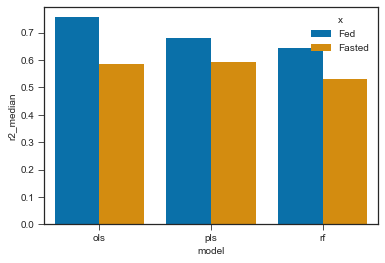

In [46]:
sns.barplot(
    data=rdf, x='model', y='r2_median', hue='x', palette=colors,
    saturation=0.90,
)

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif


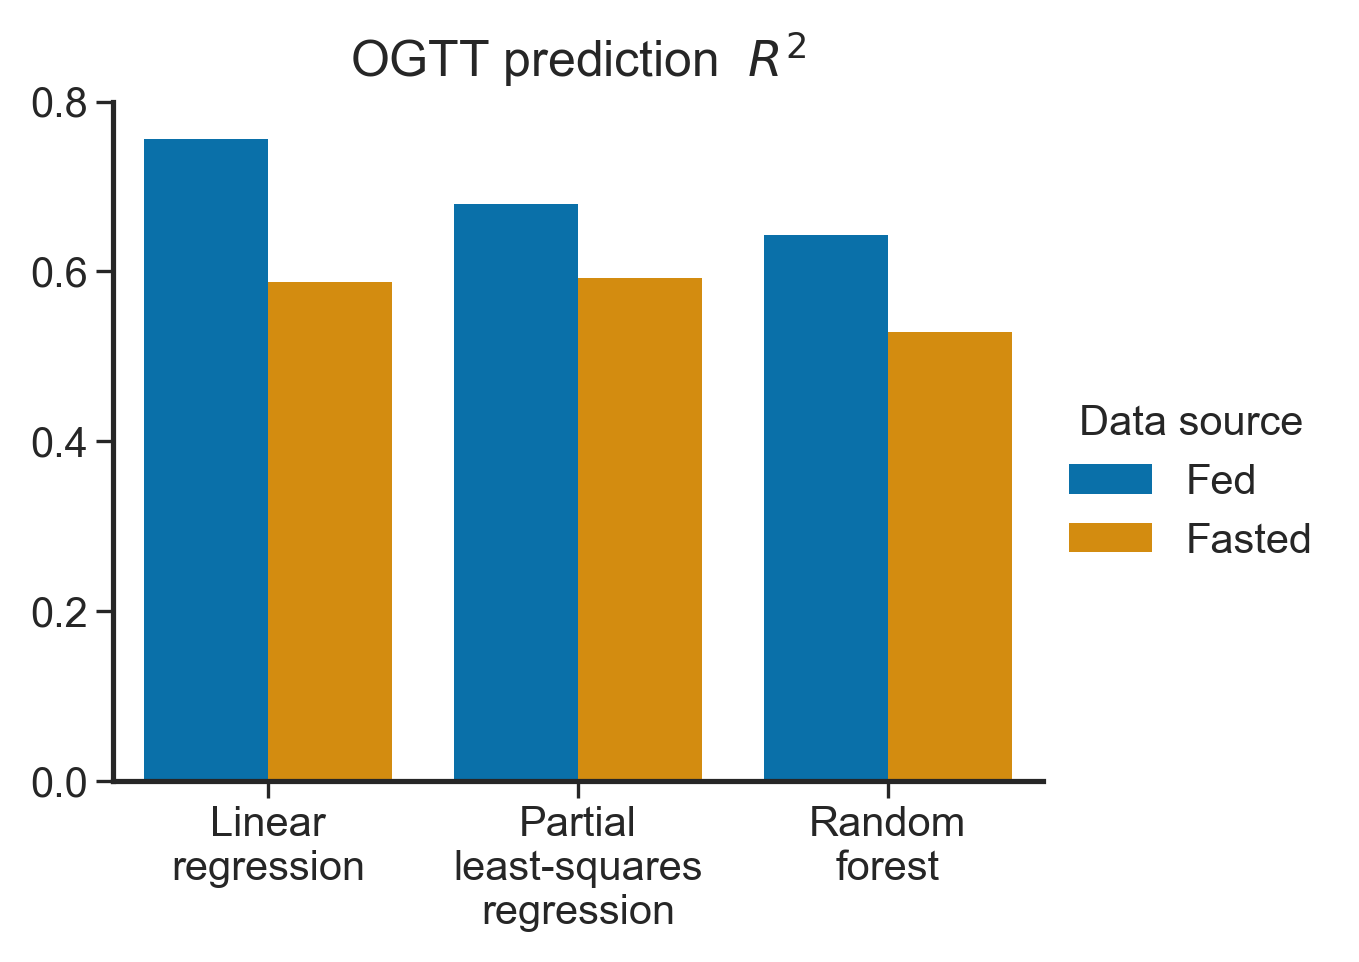

In [58]:
colors['Fed'] = colors['Non-fasted']

fig, ax = plt.subplots(dpi=300, figsize=(4, 3), facecolor='white')

rdf = r.loc[r['model'].isin(['ols', 'pls', 'rf'])]

sns.barplot(
    data=rdf, x='model', y='r2_median', hue='x', palette=colors,
    saturation=0.90,
)
ax.tick_params(pad=2, length=4, labelsize=10)
ax.set_title('OGTT prediction  $R^2$')
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_xticks([0, 1, 2], ['Linear\nregression', 'Partial\nleast-squares\nregression', 'Random\nforest'])
ax.legend(loc=(1.01, 0.3), title='Data source')
sns.despine()
plt.savefig('../reports/figures/Figure6/model_median_R2_fasted_vs_fed.pdf', dpi=300, bbox_inches='tight')

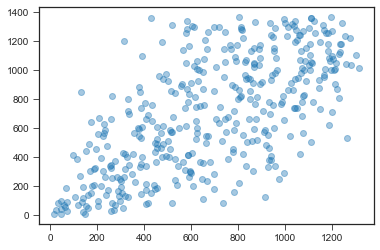

In [187]:
plt.scatter(ids_ranks['Fasted'], ids_ranks['qval_fasted'], alpha=0.4)

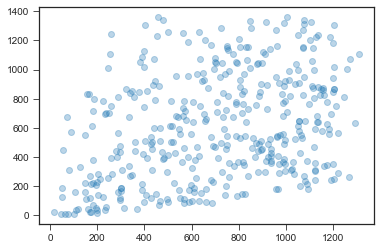

In [184]:
plt.scatter(ids_ranks['Fed'], ids_ranks['qval_fed'], alpha=0.3)

# Package `LazyPredict` uses different regression models and quickly outputs results
## However it has dumb dependencies which downgrades pandas, scipy, scikit-learn
## Use its list https://lazypredict.readthedocs.io/en/latest/usage.html#regression to re-create the list of regressors 

In [6]:
from sklearn.linear_model import (
    LinearRegression, HuberRegressor, Ridge, Lars, Lasso, ElasticNet, BayesianRidge, 
    ARDRegression, Hinge, GammaRegressor, LassoLars, LassoLarsIC, ModifiedHuber, PassiveAggressiveRegressor,
    QuantileRegressor, SGDRegressor, TheilSenRegressor, TweedieRegressor, OrthogonalMatchingPursuit
)

from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
    HistGradientBoostingRegressor, RandomForestRegressor, 
)
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [49]:
models = [
    (LinearRegression,  'Linear'),
    (HuberRegressor,  'Linear'),
    (Ridge,  'Linear'),
    (Lars,  'Linear'),
    (Lasso,  'Linear'),
    (ElasticNet, 'Linear'),
    (BayesianRidge,  'Linear'),
#   (  ARDRegression, # ARDRegression takes forever ),
#   (  Hinge,  # doesn't implement .fit() ),
    (GammaRegressor, 'Linear'),
    (LassoLars,  'Linear'),
#   (  LassoLarsIC,  # doesn't work ),
#   (  ModifiedHuber,  # doesn't implement .fit() ),
#   (  PassiveAggressiveRegressor,  # All fits failed ),
    (QuantileRegressor, 'Linear'),
    (SGDRegressor,  'Linear'),
    (TheilSenRegressor, 'Linear'),
    (TweedieRegressor, 'Linear'),
    (OrthogonalMatchingPursuit, 'Linear'),
    (SVR, 'Support vector'),
    (LinearSVR, 'Support vector'),
    (NuSVR, 'Support vector'),
    (DecisionTreeRegressor, 'Decision tree'),
    (ExtraTreeRegressor, 'Decision tree'),
    (DummyRegressor, 'Baseline'),
    (AdaBoostRegressor, 'Decision tree'),
    (BaggingRegressor, 'Decision tree'),
    (ExtraTreesRegressor, 'Decision tree'),
    (GradientBoostingRegressor,  'Decision tree'),
    (HistGradientBoostingRegressor, 'Decision tree'),
    (RandomForestRegressor, 'Decision tree'),
    (MLPRegressor, 'Neural network'),
    (KernelRidge, 'Kernel'),
    (GaussianProcessRegressor, 'Gaussian process'),
    (KNeighborsRegressor, 'Neighbors'),
    (PLSRegression, 'Latent regression'),
]
model_type_dict = {}
models_dict = {}
for model, _type in models:
    name = str(model).split('.')[-1].split("'")[0]
#     print(name)
    models_dict[name] = model()
    model_type_dict[name] = _type
models_dict

{'LinearRegression': LinearRegression(),
 'HuberRegressor': HuberRegressor(),
 'Ridge': Ridge(),
 'Lars': Lars(),
 'Lasso': Lasso(),
 'ElasticNet': ElasticNet(),
 'BayesianRidge': BayesianRidge(),
 'GammaRegressor': GammaRegressor(),
 'LassoLars': LassoLars(),
 'QuantileRegressor': QuantileRegressor(),
 'SGDRegressor': SGDRegressor(),
 'TheilSenRegressor': TheilSenRegressor(max_subpopulation=10000),
 'TweedieRegressor': TweedieRegressor(),
 'OrthogonalMatchingPursuit': OrthogonalMatchingPursuit(),
 'SVR': SVR(),
 'LinearSVR': LinearSVR(),
 'NuSVR': NuSVR(),
 'DecisionTreeRegressor': DecisionTreeRegressor(),
 'ExtraTreeRegressor': ExtraTreeRegressor(),
 'DummyRegressor': DummyRegressor(),
 'AdaBoostRegressor': AdaBoostRegressor(),
 'BaggingRegressor': BaggingRegressor(),
 'ExtraTreesRegressor': ExtraTreesRegressor(),
 'GradientBoostingRegressor': GradientBoostingRegressor(),
 'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
 'RandomForestRegressor': RandomForestRegresso

In [8]:
# X_test, y_test, X_train, y_train = train_test_split(X_scaled, y_ogtt, train_size=0.8, test_size=0.2, random_state=33)
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=43)

In [9]:
results = {}

In [13]:
for bg_type, cols in [('RBG', rbg_cols), ('FBG', fbg_cols)]:
    results[bg_type] = {}
    for model_name, model in models_dict.items():
        print(model_name)
        if model_name in results:
            print('already found, continuing')
            continue
        try:
            result = cross_validate(estimator=model,
                                    X=X_scaled.loc[cols], 
                                    y=y_ogtt.loc[cols], 
                                    cv=rkf_cv,
                                    scoring=['r2', 'neg_mean_squared_error'], 
                                    n_jobs=7)
            results[bg_type][model_name] = {
                'R2': result['test_r2'].mean(), 
                'MSE': result['test_neg_mean_squared_error'].mean() * -1,
                'Time Taken': result['score_time'].mean()
            }
        except Exception as e:
            print(model_name, e)
#         if model_name == 'Ridge':
#             break

LinearRegression
HuberRegressor
Ridge
Lars
Lasso
ElasticNet
BayesianRidge
GammaRegressor
LassoLars
QuantileRegressor
SGDRegressor
TheilSenRegressor
TweedieRegressor
OrthogonalMatchingPursuit
SVR
LinearSVR
NuSVR
DecisionTreeRegressor
ExtraTreeRegressor
DummyRegressor
AdaBoostRegressor
BaggingRegressor
ExtraTreesRegressor
GradientBoostingRegressor
HistGradientBoostingRegressor
RandomForestRegressor
MLPRegressor
KernelRidge
GaussianProcessRegressor
KNeighborsRegressor
PLSRegression
LinearRegression
HuberRegressor
Ridge
Lars
Lasso
ElasticNet
BayesianRidge
GammaRegressor
LassoLars
QuantileRegressor
SGDRegressor
TheilSenRegressor
TweedieRegressor
OrthogonalMatchingPursuit
SVR
LinearSVR
NuSVR
DecisionTreeRegressor
ExtraTreeRegressor
DummyRegressor
AdaBoostRegressor
BaggingRegressor
ExtraTreesRegressor
GradientBoostingRegressor
HistGradientBoostingRegressor
RandomForestRegressor
MLPRegressor
KernelRidge
GaussianProcessRegressor
KNeighborsRegressor
PLSRegression


In [15]:
fbg_result = pd.DataFrame.from_dict(results['FBG'], orient='index')
# fbg_result = fbg_result.sort_values('RMSE')
fbg_result = fbg_result.drop(['SGDRegressor', 'Lars'])
fbg_result = fbg_result.drop('Time Taken', axis=1)

rbg_result = pd.DataFrame.from_dict(results['RBG'], orient='index')
# rbg_result = rbg_result.sort_values('RMSE')
rbg_result = rbg_result.drop(['SGDRegressor', 'Lars'])
rbg_result = rbg_result.drop('Time Taken', axis=1)
rbg_result

,R2,MSE
LinearRegression,0.647646,4.141547e+07
HuberRegressor,0.084919,1.031551e+08
Ridge,0.648337,4.114161e+07
Lasso,0.518801,4.593012e+07
ElasticNet,0.620291,4.472367e+07
BayesianRidge,0.648431,4.113092e+07
GammaRegressor,0.526632,5.255122e+07
LassoLars,0.566521,5.493447e+07
QuantileRegressor,-0.370246,1.882587e+08
TheilSenRegressor,0.082422,1.036218e+08


In [70]:
final = rbg_result.join(fbg_result, lsuffix=' nonfasted', rsuffix=' fasted')
final = final.sort_values('MSE nonfasted')
final = final[['R2 nonfasted', 'R2 fasted', 'MSE nonfasted', 'MSE fasted']]
final['Type'] = final.index.map(model_type_dict)
final

,R2 nonfasted,R2 fasted,MSE nonfasted,MSE fasted,Type
BayesianRidge,0.648431,0.452264,4.113092e+07,5.751859e+07,Linear
Ridge,0.648337,0.452405,4.114161e+07,5.751961e+07,Linear
TweedieRegressor,0.646148,0.455255,4.139769e+07,5.756704e+07,Linear
LinearRegression,0.647646,0.446255,4.141547e+07,5.862500e+07,Linear
ElasticNet,0.620291,0.441595,4.472367e+07,5.870441e+07,Linear
Lasso,0.518801,0.018363,4.593012e+07,8.207804e+07,Linear
PLSRegression,0.578858,0.486735,4.867471e+07,5.749081e+07,Latent regression
ExtraTreesRegressor,0.580194,0.580956,4.995233e+07,4.616950e+07,Decision tree
GammaRegressor,0.526632,0.096355,5.255122e+07,8.493014e+07,Linear
LassoLars,0.566521,0.295754,5.493447e+07,6.477343e+07,Linear


In [74]:
(final['Type'].unique())

array(['Linear', 'Latent regression', 'Decision tree', 'Neighbors',
       'Kernel', 'Baseline', 'Support vector', 'Neural network',
       'Gaussian process'], dtype=object)

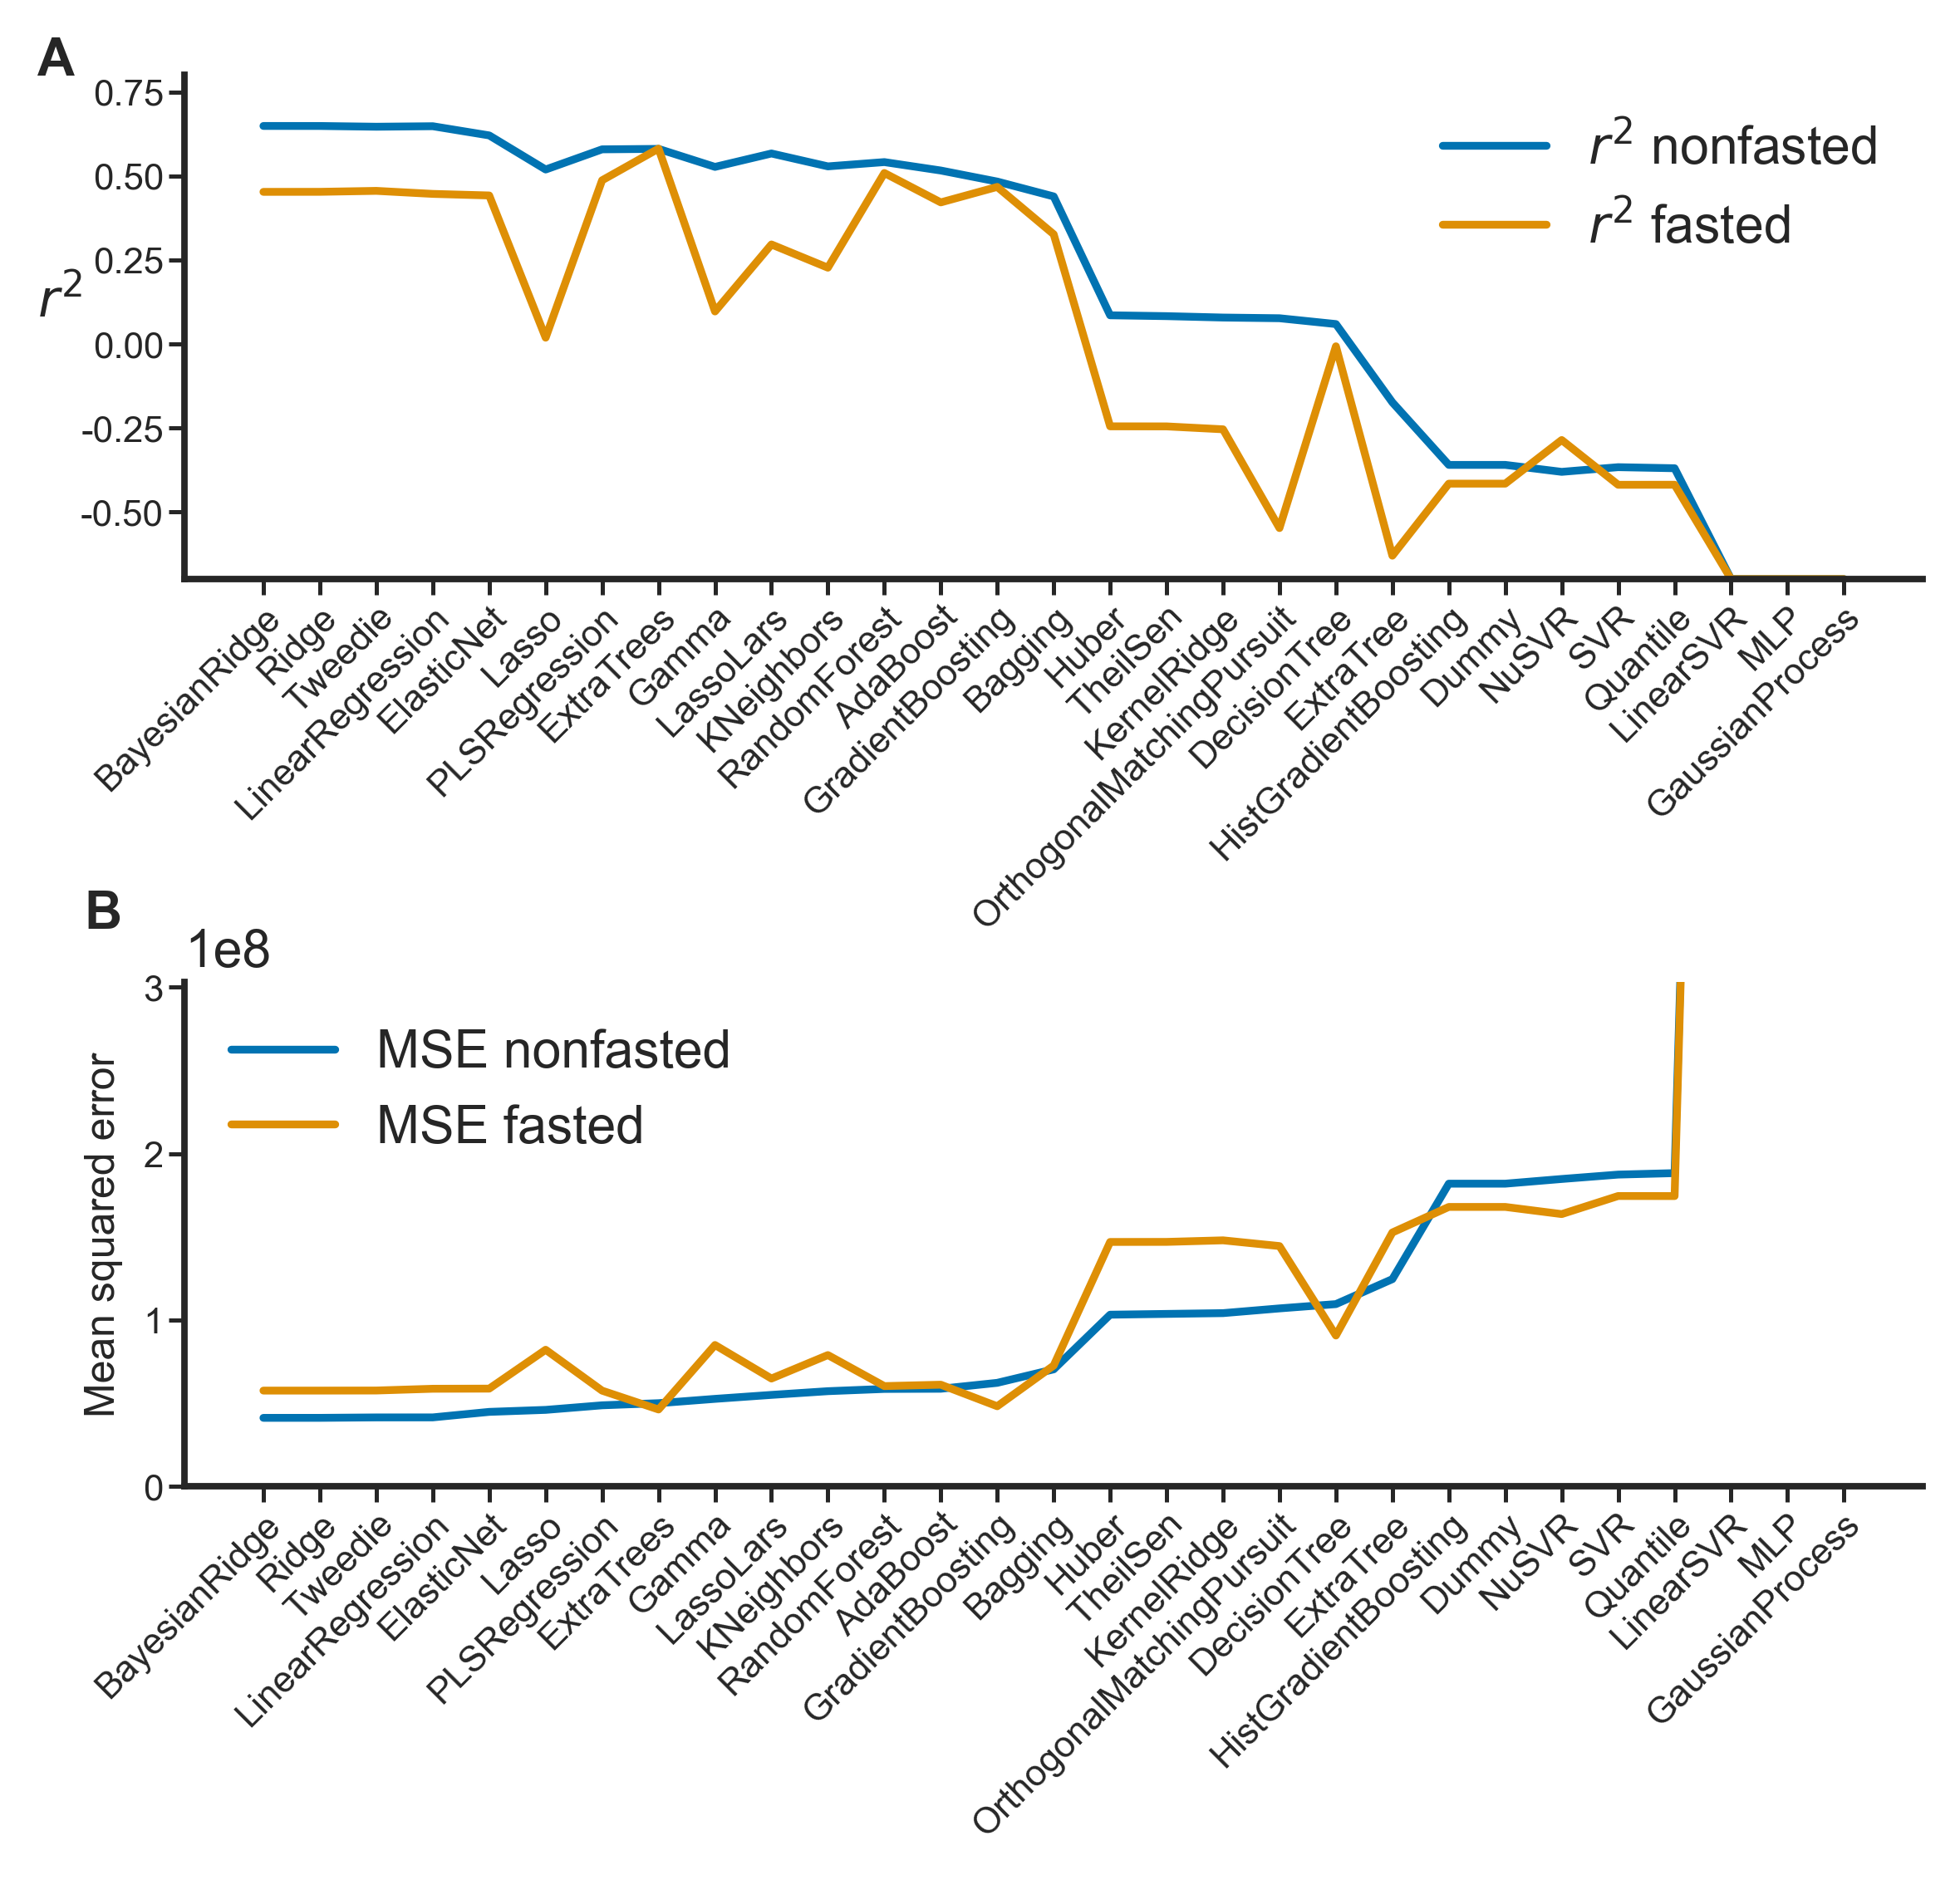

In [69]:
colors['R2 nonfasted'] = colors['RBG']
colors['R2 fasted'] = colors['FBG']
colors['MSE nonfasted'] = colors['RBG']
colors['MSE fasted'] = colors['FBG']

labels = [model.split('Regressor')[0] for model in final.index]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 5), dpi=450, facecolor='white', gridspec_kw=dict(hspace=0.8))
lower_clip = -0.7
df = final.iloc[:, :-1].clip(lower=lower_clip, upper=3e8)
df[['R2 nonfasted', 'R2 fasted']].plot(ax=ax1, color=colors)
ax1.set_xticks(ticks=range(len(final)), labels=labels, rotation=45, ha='right', fontsize=7, rotation_mode='anchor')
ax1.set_ylim(lower_clip, 0.8)
ax1.set_ylabel('$r^2$', rotation=0)

final[['MSE nonfasted', 'MSE fasted']].plot.line(ax=ax2, color=colors)
ax2.set_xticks(ticks=range(len(final)), labels=labels, rotation=45, ha='right', va='top', fontsize=7, rotation_mode='anchor')
ax2.set_ylim(0, 3.03e8)
ax2.set_ylabel('Mean squared error', fontsize=8)

for ax in [ax1, ax2]:
    ax.tick_params(length=3, pad=1, labelsize=7)
ax1.legend(labels=['$r^2$ nonfasted', '$r^2$ fasted'])
    
for ax, letter in zip([ax1, ax2], ['A', 'B']):
    bb = tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s=letter, transform=fig.transFigure, fontweight='bold')
    
sns.despine()
plt.savefig('../reports/figures/supplemental/r2_mse_regression_models.png', facecolor='white', dpi=450, bbox_inches='tight')
plt.savefig('../reports/figures/supplemental/r2_mse_regression_models.pdf', facecolor='white', dpi=450, bbox_inches='tight')

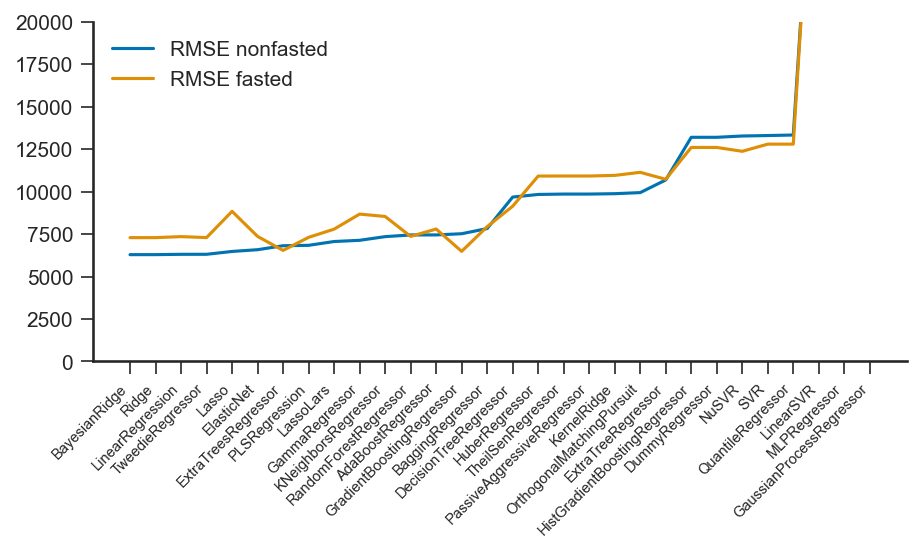

In [91]:

sns.despine()